# Inverted Pendulum on a Drone

In [436]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from numpy import linalg
import scipy

import json
from scipy import linalg
from sympy.physics.mechanics import *

### Standard Inverted Pendulum Dynamics

This is based on the Kinematics derivation of just the drone with the addition of the kinematics of the pendulum's angle.

Define states

In [437]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# states of the pendulum
alpha, alpha_dot = sym.symbols('alpha, alpha_dot')

Define inputs

In [438]:
# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

Define parameters.
$m_{pen}$ is the mass of the pendulum and $l_{pen}$ is the distance of the center of mass of the pendulum from its base.

In [439]:
m, J_x, J_y, J_z, g, m_pen, l_pen = sym.symbols('m, J_x, J_y, J_z, g, m_pen, l_pen')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [440]:
v_01in1 = sym.Matrix([v_x, v_y, v_z])
w_01in1 = sym.Matrix([w_x, w_y, w_z])

Create moment of inertia matrix (in coordinates of the body frame).

In [441]:
J_in1 = sym.diag(J_x, J_y, J_z)

## 2.2 Define kinematics of orientation

### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [442]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [443]:
R_1in0 = Rz * Ry * Rx

In [444]:
R_1in0

⎡cos(ψ)⋅cos(θ)  sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)  sin(φ)⋅sin(ψ) + sin(θ)⋅c
⎢                                                                             
⎢sin(ψ)⋅cos(θ)  sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)  -sin(φ)⋅cos(ψ) + sin(ψ)⋅
⎢                                                                             
⎣   -sin(θ)                sin(φ)⋅cos(θ)                          cos(φ)⋅cos(θ

os(φ)⋅cos(ψ) ⎤
             ⎥
sin(θ)⋅cos(φ)⎥
             ⎥
)            ⎦

### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [445]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [446]:
N = sym.simplify(Ninv.inv())

In [447]:
N

⎡      sin(φ)         cos(φ)    ⎤
⎢0     ──────         ──────    ⎥
⎢      cos(θ)         cos(θ)    ⎥
⎢                               ⎥
⎢0     cos(φ)         -sin(φ)   ⎥
⎢                               ⎥
⎣1  sin(φ)⋅tan(θ)  cos(φ)⋅tan(θ)⎦

### Deriving the Kinematics of the Pendulum

Generalized Co-ordinates: $x$, $z$ (in the world frame), $\theta$ (pitch) and $\alpha$ (angle of the drone from the world $z_0$)


![pendulum_kin](Inverted_Pendulum_Kinematics.jpg)

In [448]:
dyn_o_x, dyn_o_z, dyn_alpha, dyn_theta = dynamicsymbols(r'o_x o_z \alpha \theta')
dyn_o_xd, dyn_o_zd, dyn_alphad, dyn_thetad = dynamicsymbols(r'o_x o_z \alpha \theta', 1)
dyn_o_xdd, dyn_o_zdd, dyn_alphadd, dyn_thetadd = dynamicsymbols(r'o_x o_z \alpha \theta', 2)
L_with_z = 1/2*m*(dyn_o_xd**2 + dyn_o_zd**2) + 1/2*J_y*(dyn_thetad**2) + 1/2*m_pen*(dyn_o_xd**2 + dyn_o_zd**2 + l_pen**2 * dyn_alphad**2 + 2*l_pen*dyn_alphad*(dyn_o_xd*sym.cos(dyn_alpha) - dyn_o_zd*sym.sin(dyn_alpha)) - m*g*dyn_o_z - m_pen*g*(dyn_o_z + l_pen*sym.cos(dyn_alpha)))

LM_with_z = LagrangesMethod(L_with_z, [dyn_o_x, dyn_o_z, dyn_alpha, dyn_theta])
mechanics_printing(pretty_print=True)
Equations_with_z = LM_with_z.form_lagranges_equations()
Equations_with_z

⎡                                                                             
⎢                                                             1.0⋅m⋅oₓ̈ + 0.5⋅
⎢                                                                             
⎢                                                                             
⎢                                               1.0⋅m⋅o_̈z - 0.5⋅mₚₑₙ⋅(-g⋅m - 
⎢                                                                             
⎢         ⎛      2                                                            
⎢0.5⋅mₚₑₙ⋅⎝2⋅lₚₑₙ ⋅\alp̈ha + 2⋅lₚₑₙ⋅(-sin(\alpha)⋅\alṗha⋅oₓ̇ - sin(\alpha)⋅o_
⎢                                                                             
⎣                                                                             

    ⎛                           2                                   ⎞         
mₚₑₙ⋅⎝- 2⋅lₚₑₙ⋅sin(\alpha)⋅\alṗha  + 2⋅lₚₑₙ⋅cos(\alpha)⋅\alp̈ha + 2⋅oₓ̈⎠     
                                                   

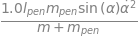

In [492]:
alpha_ddot_eqn = sym.solve(Equations_with_z[2], dyn_alphadd)[0]
Equation_0 = Equations_with_z[0].subs(dyn_alphadd, alpha_ddot_eqn)
ox_ddot_with_alphaddot_zddot = sym.solve(Equation_0, dyn_o_xdd)[0]
Equation_1 = Equations_with_z[1].subs(dyn_alphadd, alpha_ddot_eqn)
Equation_1_subbed = Equation_1.subs(dyn_o_xdd, ox_ddot_with_alphaddot_zddot)
oz_ddot_soln = sym.solve(Equation_1_subbed, dyn_o_zdd)[0]
oz_ddot_soln
ox_ddot_soln = sym.simplify(ox_ddot_with_alphaddot_zddot.subs(dyn_o_zdd, oz_ddot_soln))
alpha_ddot_soln = sym.simplify(alpha_ddot_eqn.subs([(dyn_o_xdd, ox_ddot_soln), (dyn_o_zdd, oz_ddot_soln)]))
alpha_ddot_soln


# ox_ddot_with_alphaddot = sym.solve(Equations_with_z[0], dyn_o_xdd)[0]
# oz_ddot_with_alphaddot = sym.solve(Equations_with_z[1], dyn_o_zdd)[0]
# alpha_ddot_eqn = Equations_with_z[2].subs([(dyn_o_xdd, ox_ddot_with_alphaddot), (dyn_o_zdd, oz_ddot_with_alphaddot)])
# alpha_ddot_soln = sym.simplify(sym.solve(alpha_ddot_eqn, dyn_alphadd)[0])
# alpha_ddot_soln
ox_ddot_soln

In [450]:
# Get expressions for oxddot, ozddot and alphaddot wrt only the states
# # Lambdify, linearize about the equilibrium point but replace theta ddot to be tau_y
f_planar_eq = []
# Compare to Bretl's

In [451]:
# oz_ddot_soln =  sym.solve(Equations_with_z[1], dyn_o_zdd)[0]
# oz_ddot_soln

Solving the kinematic equation for $\ddot{\alpha}$:

In [452]:
alpha_ddot_soln = sym.solve(Equations_with_z[2], dyn_alphadd)[0]
alpha_ddot_soln = alpha_ddot_soln.subs(dyn_alpha, alpha)
alpha_ddot_soln

The equation for $\ddot{\alpha}$ is still in terms of $\ddot{o_x}$ and $\ddot{o_z}$. In the notebook `acceleration_derivation.ipynb`, these are recalculated to be in terms of the states in $s$. The result is typed out here.

In [453]:
o_x_ddot = f_z*(sym.sin(phi)*sym.sin(psi) + sym.sin(theta)*sym.cos(phi)*sym.cos(psi))/m
o_z_ddot = f_z*(sym.cos(phi)*sym.cos(theta))/m - g

In [454]:
alpha_ddot_soln = sym.simplify(alpha_ddot_soln.subs([(dyn_o_xdd, o_x_ddot), (dyn_o_zdd, o_z_ddot)]))
alpha_ddot_soln

## 2.3 Define equations of motion

This is where this document differs  widely from the standard equations of motion given in the class. The pendulum's affect on the motion of the drone is assumed to be negligible (is this true for the crazyflie? idk, we'll see)

Forces.

In [455]:
f_in1 = R_1in0.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])

Torques.

In [456]:
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])

In [457]:
f_in1

⎡      g⋅m⋅sin(θ)       ⎤
⎢                       ⎥
⎢  -g⋅m⋅sin(φ)⋅cos(θ)   ⎥
⎢                       ⎥
⎣f_z - g⋅m⋅cos(φ)⋅cos(θ)⎦

In [458]:
tau_in1

⎡τₓ ⎤
⎢   ⎥
⎢τ_y⎥
⎢   ⎥
⎣τ_z⎦

Create equations of motion.

In [459]:
f_sym = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
                          J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)),
                          sym.Matrix([alpha_dot]),
                          sym.Matrix([alpha_ddot_soln])
                          )

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

for states

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \\ \alpha \\ \dot{\alpha} \end{bmatrix},
$$

inputs
$$
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \\ m_{pen} \\ l_{pen} \end{bmatrix}.
$$

In [460]:
f_sym

⎡vₓ⋅cos(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(θ)⋅cos(ψ) - sin(ψ)⋅cos(φ)) + v_z⋅(sin(φ)⋅s
⎢                                                                             
⎢vₓ⋅sin(ψ)⋅cos(θ) + v_y⋅(sin(φ)⋅sin(ψ)⋅sin(θ) + cos(φ)⋅cos(ψ)) + v_z⋅(-sin(φ)⋅
⎢                                                                             
⎢                            -vₓ⋅sin(θ) + v_y⋅sin(φ)⋅cos(θ) + v_z⋅cos(φ)⋅cos(θ
⎢                                                                             
⎢                                          w_y⋅sin(φ)   w_z⋅cos(φ)            
⎢                                          ────────── + ──────────            
⎢                                            cos(θ)       cos(θ)              
⎢                                                                             
⎢                                          w_y⋅cos(φ) - w_z⋅sin(φ)            
⎢                                                                             
⎢                                wₓ + w_y⋅sin(φ)⋅tan

# 3. Derive state-space model

## 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a list of states, inputs, and parameters as symbolic variables.

In [461]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, alpha, alpha_dot]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, J_x, J_y, J_z, g, m_pen, l_pen]

Create a list of states to track as symbolic variables. These are states whose desired values will be specified by a client.

In [462]:
s_with_des = [o_x, o_y, o_z]

Create a function that evaluates $f(\cdot)$ at particular values of $s$, $i$, and $p$.

In [463]:
f = sym.lambdify(s + i + p, f_sym)

In [464]:
f

<function _lambdifygenerated(o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, alpha, alpha_dot, tau_x, tau_y, tau_z, f_z, m, J_x, J_y, J_z, g, m_pen, l_pen)>

Define constants.

In [465]:
# Mass
m = 0.044

# Principle moments of inertia
J_x = 1.57e-05
J_y = 1.60e-05
J_z = 2.05e-05

# Acceleration of gravity
g = 9.81

# Pendulum parameters
l_pen = 150e-3 # maybe m
m_pen = 0.006

Create a list of parameter values in the **same order** as the symbolic list. These are the parameter estimates we found in our experiments. They are not choices. (We use the subscript `_eq` to be consistent with what follows, and could say "parameter values *at equilibrium*," but don't be misled. These parameter values are *given* and are *constant* - again, they aren't choices.)

In [466]:
p_eq = [m, J_x, J_y, J_z, g, m_pen, l_pen]

Create a list of state and input values at equilibrium in the **same order** as the symbolic lists.

In [467]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
i_eq = [0., 0., 0., g*m]

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be an array of zeros:

In [468]:
print(f(*s_eq, *i_eq, *p_eq))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Note that this equilibrium point would remain an equilibrium point for any choice of `o_x`, `o_y`, and `o_z` - that is one thing that allows the controller to track desired values of these variables.

## 3.2 Compute A and B

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

In [469]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

Then, we create functions that allow us to evaluate these Jacobians at particular values of $s$, $i$, and $p$.

In [470]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

Finally, we plug in our equilibrium point.

In [471]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

Show $A$ (formatted nicely).

In [472]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00  0.00  0.00  1.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  9.81  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00 -9.81 -0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]

Show $B$ (formatted nicely).

In [473]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'B = {B_str}')

B = [[      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00      22.73]
     [  63694.27       0.00       0.00       0.00]
     [      0.00   62500.00       0.00       0.00]
     [      0.00       0.00   48780.49       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]]


In [474]:
# Saving A and B to MATLAB 
scipy.io.savemat('./matlab_A_B.mat', mdict={'A': A, 'B': B})

The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

Note that $A$ and $B$ would remain the same for any choice of `o_x`, `o_y`, and `o_z` - that is the other thing that allows the controller to track desired values of these variables.

Check controllability:

In [475]:
W = np.block([[B, A @ B, A @ A @ B, np.linalg.matrix_power(A, 3) @ B, np.linalg.matrix_power(A, 4) @ B, np.linalg.matrix_power(A, 5) @ B, np.linalg.matrix_power(A, 6) @ B, np.linalg.matrix_power(A, 7) @ B, np.linalg.matrix_power(A, 8) @ B, np.linalg.matrix_power(A, 9) @ B, np.linalg.matrix_power(A,10) @ B, np.linalg.matrix_power(A, 11) @ B, np.linalg.matrix_power(A, 12) @ B, np.linalg.matrix_power(A, 13) @ B]])

#np.linalg.matrix_rank(W) # If 14, the system is controllable
linalg.svdvals(W)

array([4.21168654e+06, 4.21168654e+06, 6.24840764e+05, 6.24840764e+05,
       1.19062181e+05, 1.19062181e+05, 6.36942675e+04, 6.36942675e+04,
       6.25000000e+04, 6.25000000e+04, 4.87804878e+04, 4.87804878e+04,
       2.27272727e+01, 2.27272727e+01])

# 4. Design method of power distribution

It should only be necessary to do this once.

Define constants.

In [476]:
k_F = 2.04e-06
k_M = 6.33e-09
l = .0325 

Define the matrix $P$ that maps motor power commands ($m_1$, $m_2$, $m_3$, $m_4$) to inputs ($\tau_x$, $\tau_y$, $\tau_z$, $f_z$).

In [477]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Compute the matrix $P^{-1}$ that maps inputs to motor power commands.

In [478]:
Pinv = linalg.inv(P)

Print code that implements the method of power distribution in python (for simulation).

In [479]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')



export_power_distribution(Pinv)

m_1 = self.limitUint16( -3770739.1 * tau_x -3770739.1 * tau_y -39494470.8 * tau_z + 122549.0 * f_z )
m_2 = self.limitUint16( -3770739.1 * tau_x + 3770739.1 * tau_y + 39494470.8 * tau_z + 122549.0 * f_z )
m_3 = self.limitUint16( 3770739.1 * tau_x + 3770739.1 * tau_y -39494470.8 * tau_z + 122549.0 * f_z )
m_4 = self.limitUint16( 3770739.1 * tau_x -3770739.1 * tau_y + 39494470.8 * tau_z + 122549.0 * f_z )


Print code that implements the method of power distribution in C (for hardware).

In [480]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -3770739.1f * tau_x -3770739.1f * tau_y -39494470.8f * tau_z + 122549.0f * f_z );
m_2 = limitUint16( -3770739.1f * tau_x + 3770739.1f * tau_y + 39494470.8f * tau_z + 122549.0f * f_z );
m_3 = limitUint16( 3770739.1f * tau_x + 3770739.1f * tau_y -39494470.8f * tau_z + 122549.0f * f_z );
m_4 = limitUint16( 3770739.1f * tau_x -3770739.1f * tau_y + 39494470.8f * tau_z + 122549.0f * f_z );


## 5.1 Flight test

Each time you duplicate this section, replace the title with a brief description of your current flight test.

### 5.1.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

In [556]:
Q = np.diag([
    0.01, # x
    7., # y
    5., # z
    1., # psi (yaw)
    20., # theta (pitch)
    .01, # phi (roll)
    0.02,
    0.8,
    1.,
    1.,
    0.01,
    1.,
    10., #alpha
    2. #alpha_dot
])

R = np.diag([
    1E6, #tau_x
    1E9,#tau_y
    1E6,
    10,
])


Find $K$ for the chosen $Q$ and $R$.

Here is a function that solves the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [557]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

In [558]:
K = lqr(A, B, Q, R)

K

array([[ 2.13522248e-15, -2.64575131e-03, -2.86780871e-18,
         9.91553184e-18,  1.95083391e-13,  6.66549006e-03,
         7.49657638e-14, -2.09651082e-03, -4.79722009e-18,
         1.09968013e-03,  3.04741802e-14,  3.48546752e-17,
        -1.10217273e-14,  1.30000384e-15],
       [-3.16227765e-06,  2.24817296e-16, -1.20744007e-17,
         4.01042923e-17,  1.44413987e-03,  4.25320982e-18,
        -1.49531728e-04,  5.20277586e-17, -4.08225955e-18,
         2.99027893e-17,  2.14994129e-04, -9.19422675e-18,
        -1.08285734e-04, -1.03904412e-04],
       [ 6.56804123e-16, -1.27556850e-16,  7.81254345e-17,
         1.00000000e-03, -5.52786818e-14,  4.65341256e-16,
         3.20982259e-14, -1.26414451e-16,  9.14170050e-18,
         2.66935805e-17, -7.17598186e-15,  1.02029408e-03,
         4.91627061e-15,  8.06377663e-15],
       [ 6.01227226e-14,  1.31362015e-15,  7.07106781e-01,
         8.73117925e-16, -8.96053936e-13, -7.59055100e-15,
         2.73831957e-12,  1.56540273e-15,  4.

Show $K$ (formatted nicely).

In [559]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[ 0.000 -0.003 -0.000  0.000  0.000  0.007  0.000 -0.002 -0.000  0.001  0.000  0.000 -0.000  0.000]
     [-0.000  0.000 -0.000  0.000  0.001  0.000 -0.000  0.000 -0.000  0.000  0.000 -0.000 -0.000 -0.000]
     [ 0.000 -0.000  0.000  0.001 -0.000  0.000  0.000 -0.000  0.000  0.000 -0.000  0.001  0.000  0.000]
     [ 0.000  0.000  0.707  0.000 -0.000 -0.000  0.000  0.000  0.403 -0.000 -0.000  0.000  0.000  0.000]]


Print code that implements the controller in python (for simulation).

In [560]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')



# export_controller(
#     K,               # the gain matrix
#     s,               # list of states as symbolic variables
#     i,               # list of inputs as symbolic variables
#     s_with_des,      # list of states that have desired values as symbolic variables
#     i_eq,            # list of equilibrium values of inputs
# )

export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)


tau_x = 0.00264575 * (o_y - o_y_des) -0.00666549 * phi + 0.00209651 * v_y -0.00109968 * w_x
tau_y = 0.00000316 * (o_x - o_x_des) -0.00144414 * theta + 0.00014953 * v_x -0.00021499 * w_y + 0.00010829 * alpha + 0.00010390 * alpha_dot
tau_z = -0.00100000 * psi -0.00102029 * w_z
f_z = -0.70710678 * (o_z - o_z_des) -0.40277214 * v_z + 0.43164000


### Plot results from test (simulation or flight)

In [486]:
def load_simulation_data(filename, dronename):
    # load data for all drones
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # get data for one drone only
    data = data[dronename]
    
    # convert lists to numpy arrays
    for key in data.keys():
        if isinstance(data[key], dict):
            for subkey in data[key].keys():
                data[key][subkey] = np.array(data[key][subkey])
        else:
            data[key] = np.array(data[key])
    
    # return the data
    return data

In [565]:
data = load_simulation_data(
    '../Simulation/pendulum_initial_test.json', 
    'my_drone',              
)

In [566]:
# time
t = data['t']

# position
o_x = data['state']['o_x']
o_y = data['state']['o_y']
o_z = data['state']['o_z']

# desired position
o_x_des = data['setpoint']['o_x']
o_y_des = data['setpoint']['o_y']
o_z_des = data['setpoint']['o_z']

# orientation
psi = data['state']['psi']
theta = data['state']['theta']
phi = data['state']['phi']

# pendulum data
alpha = data['state']['alpha']
alpha_dot = data['state']['alpha_dot']

# motor power commands
m_1 = data['power']['m_1']
m_2 = data['power']['m_2']
m_3 = data['power']['m_3']
m_4 = data['power']['m_4']

# # tau
# tau_x = data['input']['tau_x']
# tau_y = data['input']['tau_y']
# tau_z = data['input']['tau_z']
# f_z = data['input']['f_z']

In [567]:
# Compute error in position (this is a function of time).
 
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Text(0.5, 0, 'time (s)')

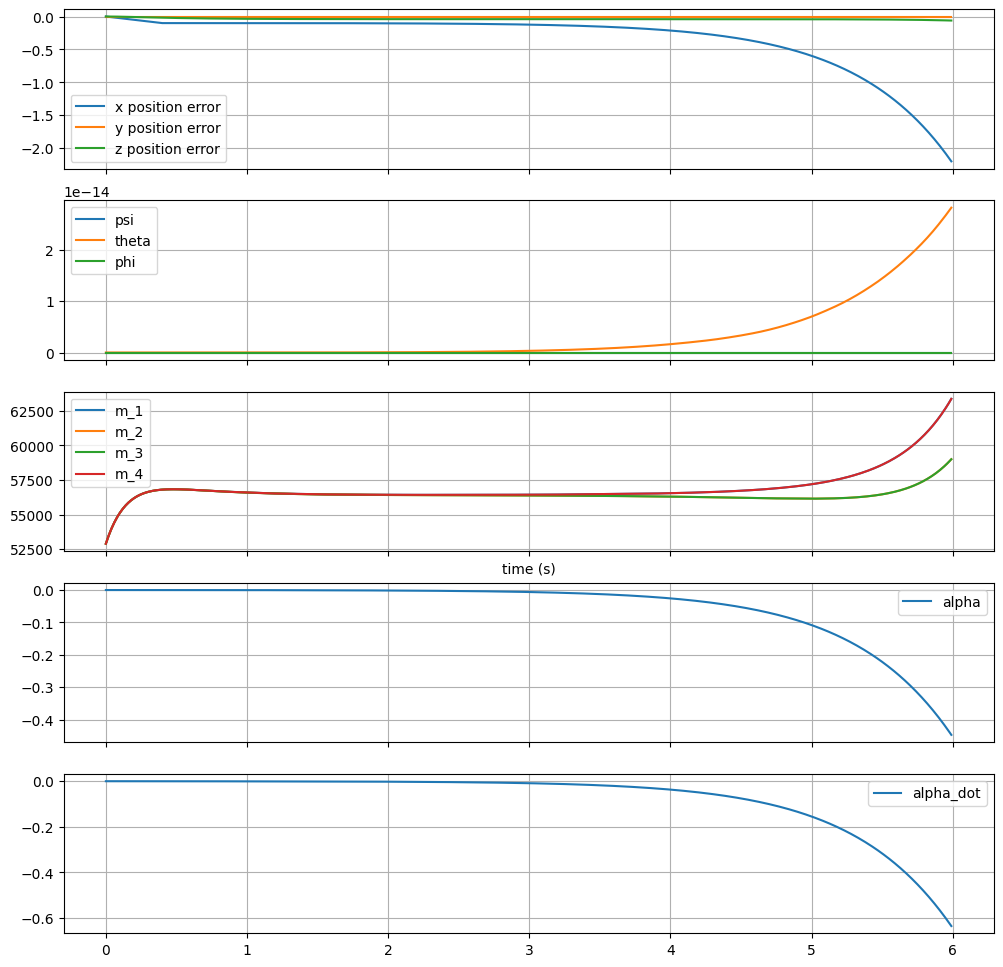

In [568]:
# Plot position error, orientation, pendulum pose and motor power commands

fig, (ax_pos, ax_ori, ax_pow, ax_pen, ax_dot_pen) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pen.plot(t, alpha, label='alpha')
ax_pen.legend()
ax_pen.grid()
ax_dot_pen.plot(t, alpha_dot, label='alpha_dot')
ax_dot_pen.legend()
ax_dot_pen.grid()
ax_pow.set_xlabel('time (s)')

In [569]:
print(o_x)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.95888613e-10  1.53522486e-09  2.42955036e-09
  3.83952300e-09  6.07343746e-09  9.05108679e-09  1.20610818e-08
  1.52054286e-08  1.86874423e-08  2.23225423e-08  2.58914935e-08
  2.97365404e-08  3.33172150e-08  3.59229499e-08  3.77587886e-08
  3.87441270e-08  3.77808185e-08  3.39554113e-08  2.72720207e-08
  1.74511113e-08  3.79341672e-09 -1.44665083e-08 -3.81595094e-08
 -6.81812300e-08 -1.05491408e-07 -1.51113210e-07 -2.06132579e-07
 -2.71101610e-07 -3.47482447e-07 -4.36934392e-07 -5.40823454e-07
 -6.59978707e-07 -7.96136356e-07 -9.51226714e-07 -1.12628787e-06
 -1.32266689e-06 -1.54275138e-06 -1.78817088e-06 -2.06050840e-06
 -2.36178904e-06 -2.69412602e-06 -3.05971998e-06 -3.46085791e-06
 -3.89991184e-06 -4.37933835e-06 -4.90227347e-06 -5.47108729e-06
 -6.08869078e-06 -6.75758021e-06 -7.48019568e-06 -8.25941009e-06
 -9.09817487e-06 -1.00001